## Imports

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import arviz as az
import theano.tensor as tt
import matplotlib.pyplot as pplt
from datetime import datetime, timedelta

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Functions

In [3]:
def minusTime(startDate, t): 
    date = datetime.strptime(startDate, '%Y-%m-%d').date()
    d = date- timedelta(days = t)
    return d.strftime('%Y-%m-%d')

def addTime(startDate, t): 
    date = datetime.strptime(startDate, '%Y-%m-%d').date()
    d = date+ timedelta(days = t)
    return d.strftime('%Y-%m-%d')

In [5]:
# here, start is a parameter that will indicate which of 3 sets of starting values to work with
def sampleMCMC(offset,data, pop, start, beta_start, gamma_start, rho_start):

    # splitting data into infections and time as numpy arrays
    dataDeath = data["cumDeath"].to_numpy()
    time = np.linspace(offset,offset+len(data)-1, len(data))

    # establishing model
    with pm.Model() as model:
        
        # create population number priors
        i0 = pm.Poisson('i0', mu=pop/10000)
        s0 = pm.Deterministic('s0', pop - i0)
        
        # creating priors for beta, gamma, and rho
        beta = pm.InverseGamma('beta', mu=.036, sigma=.5, testval=beta_start)
        gamma = pm.InverseGamma('gamma', mu=.047, sigma=.5, testval=gamma_start)
        rho = pm.TruncatedNormal('rho', mu=.034, sigma=.01, lower=0, upper=1, testval=rho_start)
        
        reproduciton = pm.Deterministic('R0', beta/gamma)

        # create number of removed based on analytic solution and above parameters
        sirRem = pm.Deterministic('sirRem',
            pop - ((s0 + i0)**(beta/(beta - gamma)))*
            (s0 + i0*tt.exp(time*(beta - gamma)))**(-gamma/(beta - gamma)))
        
        # create number of deaths as a fraction of number of removed
        sirDeath = pm.Deterministic('sirDeath', rho*sirRem)
        
        # create variance prior
        sigma = pm.HalfCauchy('sigma', beta=2)
        
        # create likelihood with modelled counts and observed counts
        obsDeath = pm.TruncatedNormal('obsDeath', mu=sirDeath, sigma=sigma,
                                     lower=0, upper=pop, observed=dataDeath)

        # specifying model conditions
        step=pm.NUTS(target_accept=.99)
        start=pm.find_MAP()
        
        # execute sampling
        model_trace = pm.sample(draws=1000, tune=1000, step=step, start=start, chains=5, cores=16)

    # return posterior samples and other information
    return model_trace

In [6]:
def runMCMC(df, population, start_date, end_date, offset, beta, gamma, rho):
    mask = (df['date'] > start_date) & (df['date'] <= end_date)
    df = df.loc[mask]
    mcmc = sampleMCMC(offset,df,population, 3, beta, gamma, rho)
    return mcmc    

In [7]:
def printMCMCTables(model):
    results = (pm.summary(model, var_names=['i0','beta','gamma','rho','sigma','R0'], round_to=5))
    return results

In [8]:
def plotMCMC(model):
    plot_trace = pm.plot_trace(model, var_names=('beta','gamma','rho','R0'), legend=True, chain_prop={"color":"rgbym"},figsize=(10.0,15.0))
    plot_pair = pm.plot_pair(model, var_names=('beta','gamma'), kind='kde')
    return plot_trace, plot_pair

## Preparing 

In [9]:
dataset = {
    'France': {
        'data' : pd.read_csv("../processed_data/cumDeathFrance.csv"),
        'fLock' : ['2020-03-17','2020-05-11'],
        'sLock' : ['2020-10-30','2020-12-15'],
        'pop' : 67413000
             },
    'Italy' : {
        'data' : pd.read_csv("../processed_data/cumDeathItaly.csv"),
        'fLock' : ['2020-03-09','2020-05-18'], 
        'sLock' : ['2020-12-24','2021-01-06'],
        'pop': 59110000
              },
    'Spain' : {
        'data' : pd.read_csv("../processed_data/cumDeathSpain.csv"),
        'fLock' : ['2020-03-14','2020-05-09'], 
        'sLock' : ['2020-03-03','2020-03-03'],
        'pop' : 47420000
              },
    'Germany' : {
        'data' : pd.read_csv("../processed_data/cumDeathGermany.csv"),
        'fLock' : ['2020-03-16','2020-05-30'], 
        'sLock' : ['2020-11-02','2021-03-01'],
        'pop' : 83000000
                },
    'UK' : {
        'data' : pd.read_csv("../processed_data/cumDeathUK.csv"),
        'fLock' : ['2020-03-23','2020-07-04'], 
        'sLock' : ['2020-11-05','2021-03-28'],
        'pop' : 67330000
           }
}

# Preparing Beta, Gamma, Rho values
beta = [0.030, 0.032, 0.035, 0.037]
gamma = [0.038, 0.040, 0.044, 0.036]
rho = [0.030, 0.032, 0.035, 0.037]

## Running Analysis

In [10]:
country_names = ['France','Germany','Italy','Spain','UK']
quarantine_one_results = []
for country in country_names:
    df = dataset[country]['data']
    pop = dataset[country]['pop']
    date = dataset[country]['fLock'][0]
    result = []

    # Before Lockdown
    try:
        result.append(runMCMC(df,pop,date,addTime(date,20),15,beta[2],gamma[2],rho[2]))
    except:
        try:
            result.append(runMCMC(df,pop,date,addTime(date,20),15,beta[1],gamma[1],rho[1]))
        except:
            try:
                result.append(runMCMC(df,pop,date,addTime(date,20),15,beta[0],gamma[2],rho[0]))
            except:
                try:
                    result.append(runMCMC(df,pop,date,addTime(date,20),15,beta[3],gamma[3],rho[3]))
                except:
                    next
    
    # After Lockdown
    try:
        result.append(runMCMC(df,pop,date, addTime(date,40),15,beta[2],gamma[2],rho[2]))
    except:
        try:
            result.append(runMCMC(df,pop,date, addTime(date,40),15,beta[1],gamma[1],rho[1]))
        except:
            try:
                result.append(runMCMC(df,pop,date, addTime(date,40),15,beta[0],gamma[2],rho[0]))
            except:
                    try:
                        result.append(runMCMC(df,pop,date,addTime(date,40),15,beta[3],gamma[3],rho[3]))
                    except:
                        next

    quarantine_one_results.append(result)

WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.


Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

Multiprocess sampling (5 chains in 16 jobs)
CompoundStep
>NUTS: [sigma, rho, gamma, beta]
>Metropolis: [i0]


/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/zenodeangeli/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 5 chains for 1_000 tune and 1_000 draw iterations (

### Store parameter values

In [11]:
country_names = ['France','Germany','Italy','Spain','UK']
for index, results in enumerate(quarantine_one_results):
    # Before
    results_before = printMCMCTables(results[0])[['mean','sd','hdi_3%','hdi_97%','r_hat']]
    results_before = results_before.loc[["beta","gamma","rho",'i0','R0']]
    results_before.to_csv('mcmc_data/' + country_names[index] + '/fLock_before.csv')

    # After
    results_after = printMCMCTables(results[1])[['mean','sd','hdi_3%','hdi_97%','r_hat']]
    results_after = results_after.loc[["beta","gamma","rho",'i0','R0']]
    results_after.to_csv('mcmc_data/' + country_names[index] + '/fLock_after.csv')

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


### Print Parameter Values (Full)

In [14]:
country_names = ['France','Germany','Italy','Spain','UK']
for index, results in enumerate(quarantine_one_results):
    print(country_names[index])
    # Before
    results_before = printMCMCTables(results[0])[['mean','sd','hdi_3%','hdi_97%','r_hat']]
    display(results_before)

    # After
    results_after = printMCMCTables(results[1])[['mean','sd','hdi_3%','hdi_97%','r_hat']]
    display(results_after)

Got error No model on context stack. trying to find log_likelihood in translation.


France


mean        sd      hdi_3%     hdi_97%    r_hat
i0     6740.32160  83.03545  6591.00000  6893.00000  1.00559
beta      0.18941   0.01144     0.17184     0.20645  1.00819
gamma     0.03200   0.01194     0.01610     0.05105  1.00976
rho       0.03679   0.00933     0.01809     0.05332  1.00832
sigma   316.24730  59.72044   216.42256   429.51555  1.00085
R0        6.43699   1.67246     3.33126     9.39151  1.00932

Got error No model on context stack. trying to find log_likelihood in translation.


mean         sd      hdi_3%     hdi_97%    r_hat
i0     6745.57400   81.07385  6584.00000  6892.00000  1.00669
beta      0.35999    0.08645     0.22537     0.51173  1.00318
gamma     0.30619    0.08851     0.16611     0.46116  1.00335
rho       0.04350    0.00900     0.02586     0.06017  1.00264
sigma  2183.41480  289.82156  1666.93134  2717.48835  1.00328
R0        1.19093    0.06127     1.08842     1.30878  1.00288

Got error No model on context stack. trying to find log_likelihood in translation.


Germany


mean        sd      hdi_3%     hdi_97%    r_hat
i0     8303.05160  92.18455  8127.00000  8469.00000  1.00305
beta      0.15546   0.00927     0.14019     0.17257  1.00393
gamma     0.03075   0.00970     0.01556     0.04859  1.00144
rho       0.03648   0.00920     0.01929     0.05315  1.00282
sigma   200.39743  36.57615   138.77695   266.02033  1.00195
R0        5.45193   1.41115     3.09353     8.16054  1.00085

Got error No model on context stack. trying to find log_likelihood in translation.


mean        sd      hdi_3%     hdi_97%    r_hat
i0     8303.63120  89.64068  8121.00000  8462.00000  1.01015
beta      0.19616   0.04037     0.13309     0.26925  1.00336
gamma     0.15932   0.04201     0.09307     0.23645  1.00323
rho       0.04362   0.00892     0.02851     0.06185  1.00261
sigma   803.85086  98.04609   634.02848   992.49479  1.00155
R0        1.24860   0.07723     1.11570     1.38963  1.00192

Got error No model on context stack. trying to find log_likelihood in translation.


Italy


mean        sd      hdi_3%     hdi_97%    r_hat
i0     5915.82820  79.79254  5771.00000  6067.00000  1.01651
beta      0.22873   0.02710     0.18601     0.27859  1.00343
gamma     0.11260   0.02841     0.06638     0.16480  1.00321
rho       0.04161   0.00878     0.02569     0.05847  1.00233
sigma   377.44123  67.09761   265.65114   506.44209  1.00299
R0        2.09654   0.27969     1.58565     2.61168  1.00327

Got error No model on context stack. trying to find log_likelihood in translation.


mean         sd      hdi_3%     hdi_97%    r_hat
i0     5914.65720   78.06955  5775.00000  6068.00000  1.00550
beta      0.56148    0.13451     0.35545     0.80414  1.01069
gamma     0.51993    0.13571     0.30752     0.76164  1.01054
rho       0.04409    0.00908     0.02692     0.06084  1.01132
sigma  1706.70069  206.93174  1340.81484  2080.72250  1.00296
R0        1.08539    0.02378     1.04401     1.12975  1.00886

Got error No model on context stack. trying to find log_likelihood in translation.


Spain


mean         sd      hdi_3%     hdi_97%    r_hat
i0     4745.22360   71.40362  4610.00000  4870.00000  1.00795
beta      0.22202    0.02131     0.18959     0.26330  1.00276
gamma     0.08056    0.02464     0.03918     0.12575  1.00255
rho       0.04031    0.00912     0.02323     0.05691  1.00257
sigma   606.41842  114.91169   419.38854   827.48345  1.00319
R0        2.93502    0.66596     1.84543     4.19176  1.00201

Got error No model on context stack. trying to find log_likelihood in translation.


mean         sd      hdi_3%     hdi_97%    r_hat
i0     4745.02040   69.02645  4622.00000  4887.00000  1.00938
beta      0.65419    0.15815     0.39139     0.94638  1.02766
gamma     0.61200    0.15998     0.34856     0.91591  1.02756
rho       0.04497    0.00924     0.02736     0.06188  1.02473
sigma  2163.29142  276.12617  1684.03999  2696.11482  1.00509
R0        1.07429    0.02359     1.03360     1.11734  1.02360

Got error No model on context stack. trying to find log_likelihood in translation.


UK


mean         sd      hdi_3%     hdi_97%    r_hat
i0     6733.32440   81.94377  6582.00000  6886.00000  1.00562
beta      0.31999    0.05103     0.23848     0.41544  1.00550
gamma     0.21064    0.05273     0.12519     0.31191  1.00507
rho       0.04318    0.00887     0.02722     0.06053  1.00608
sigma   772.51066  135.91904   550.93215  1021.53451  1.00443
R0        1.55198    0.14356     1.29799     1.82426  1.00417

Got error No model on context stack. trying to find log_likelihood in translation.


mean         sd      hdi_3%     hdi_97%    r_hat
i0     6733.52580   84.44916  6575.00000  6888.00000  1.01211
beta      0.87960    0.16610     0.58910     1.20027  1.02609
gamma     0.84084    0.16725     0.55030     1.16881  1.02541
rho       0.04592    0.00827     0.03123     0.06190  1.02040
sigma  2977.39465  355.85664  2328.35076  3656.67765  1.00647
R0        1.04825    0.01199     1.02778     1.06971  1.01574

### Graph Results of Analysis

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got 

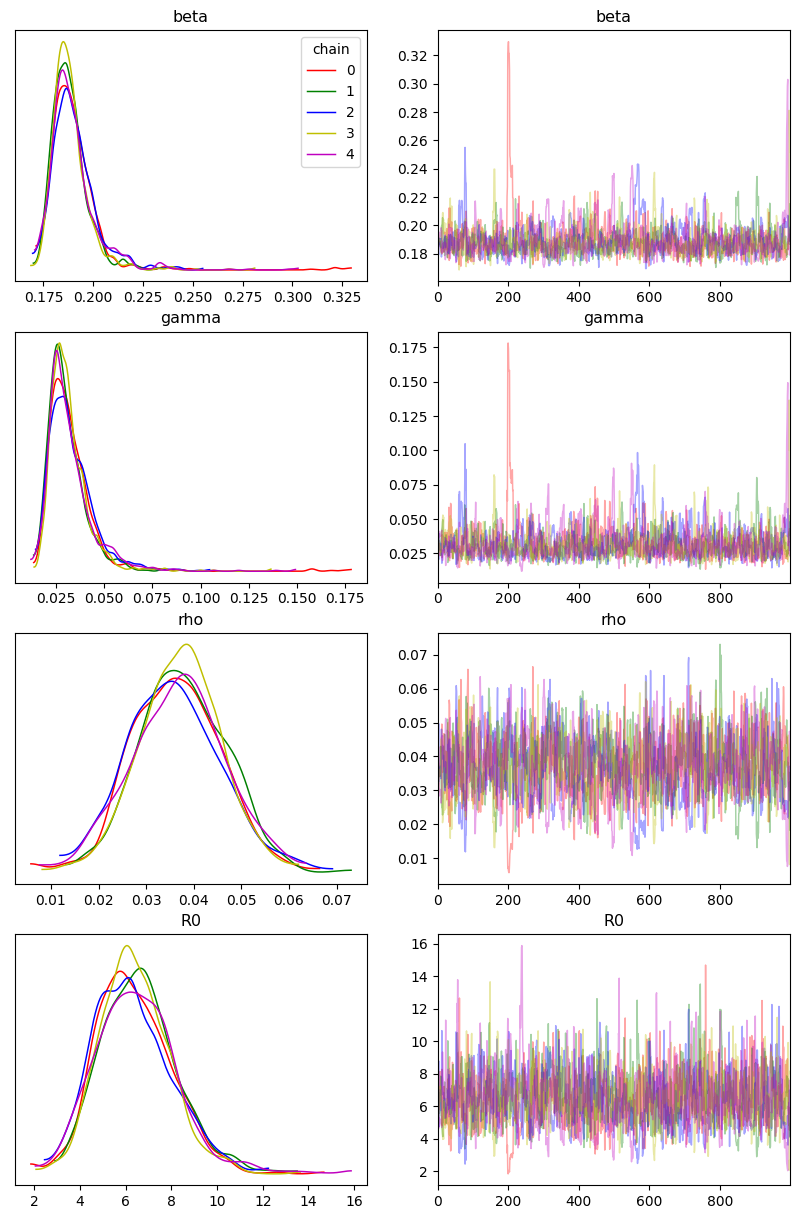

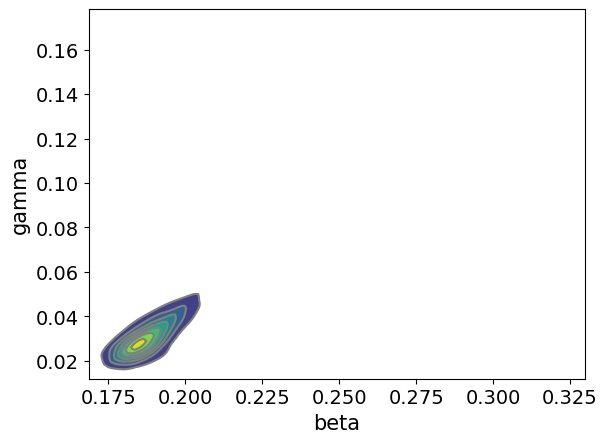

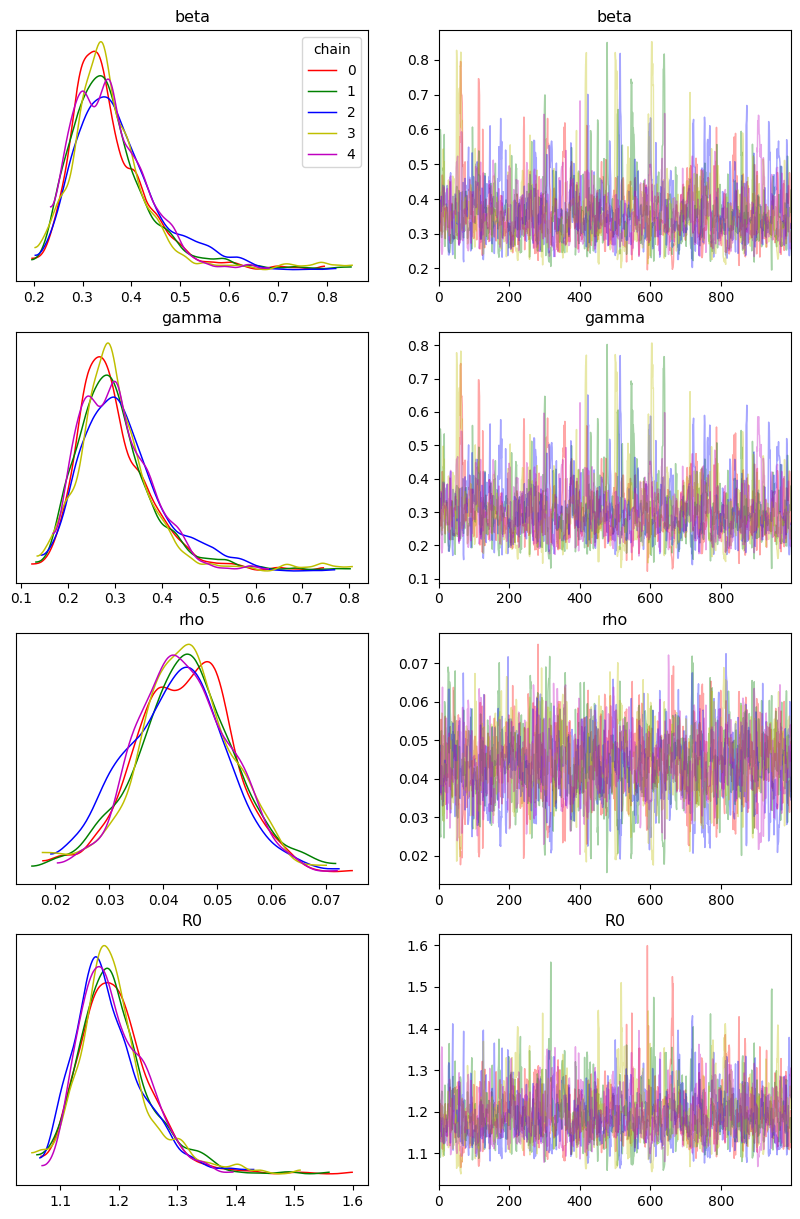

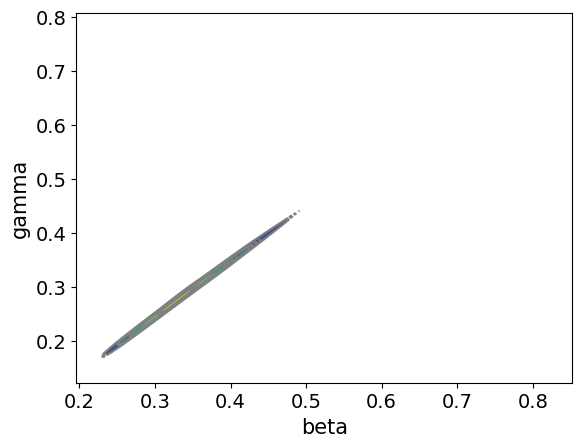

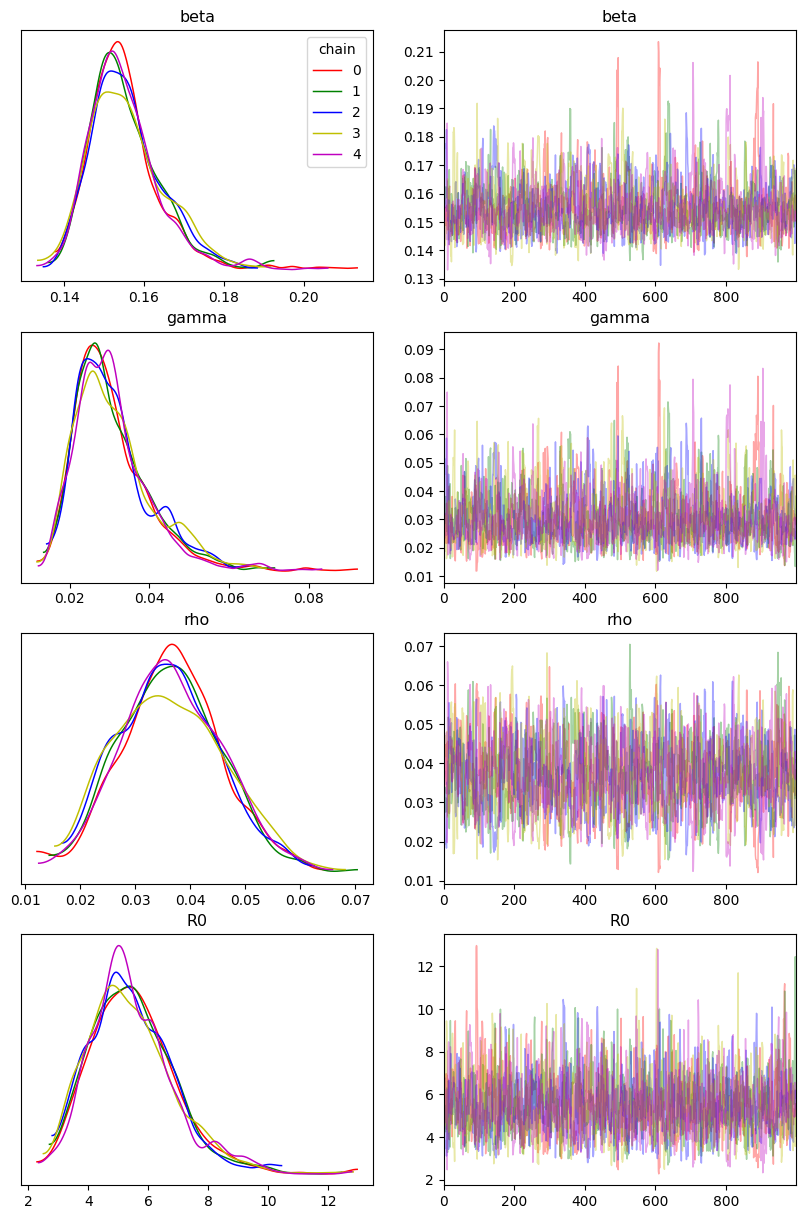

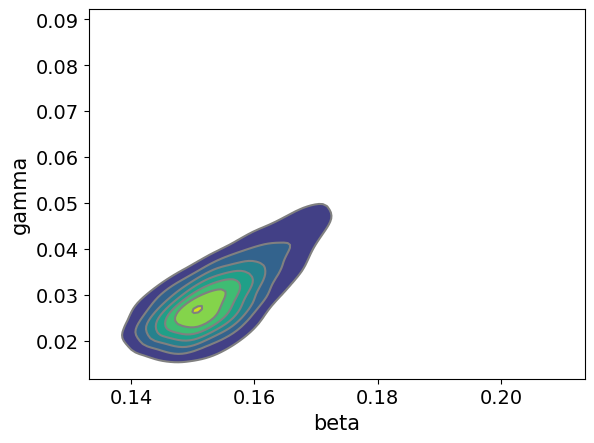

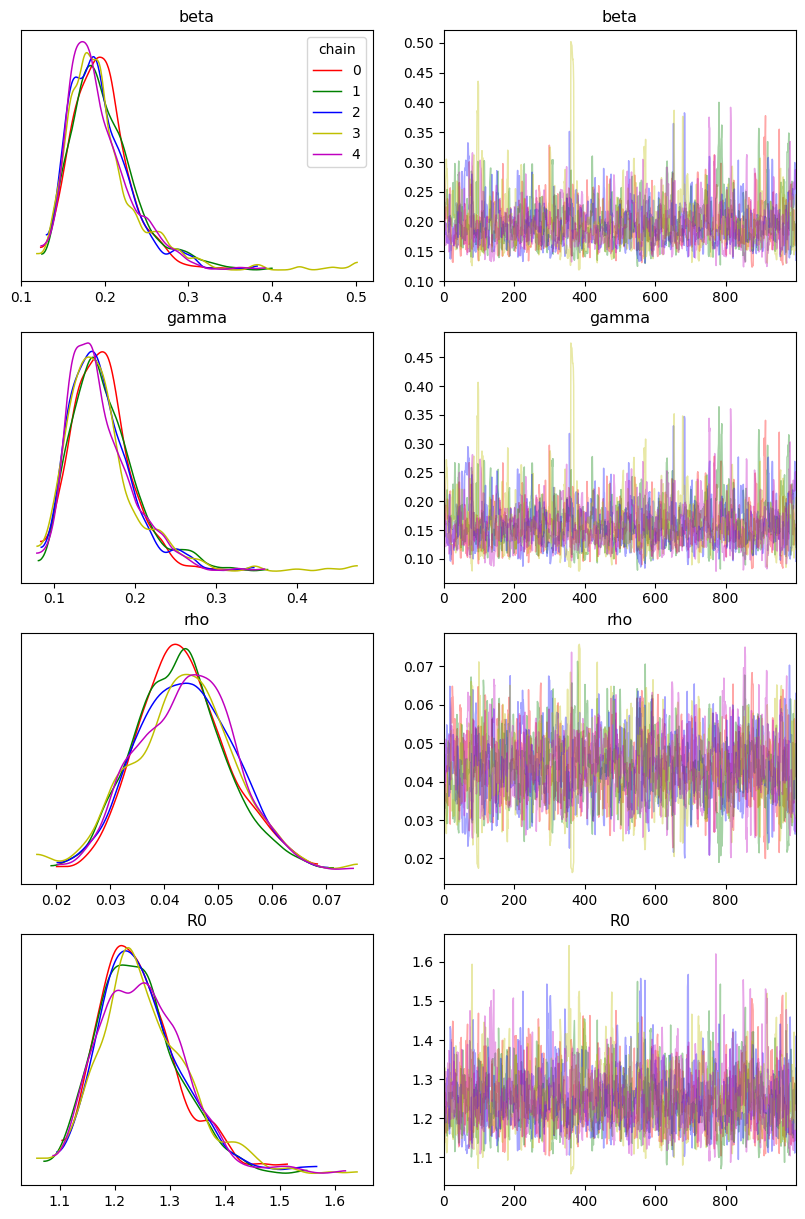

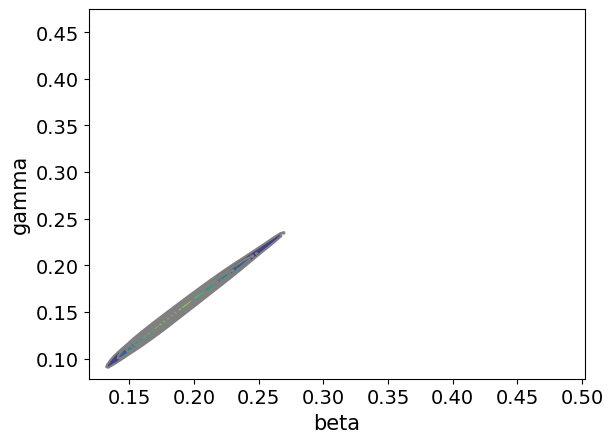

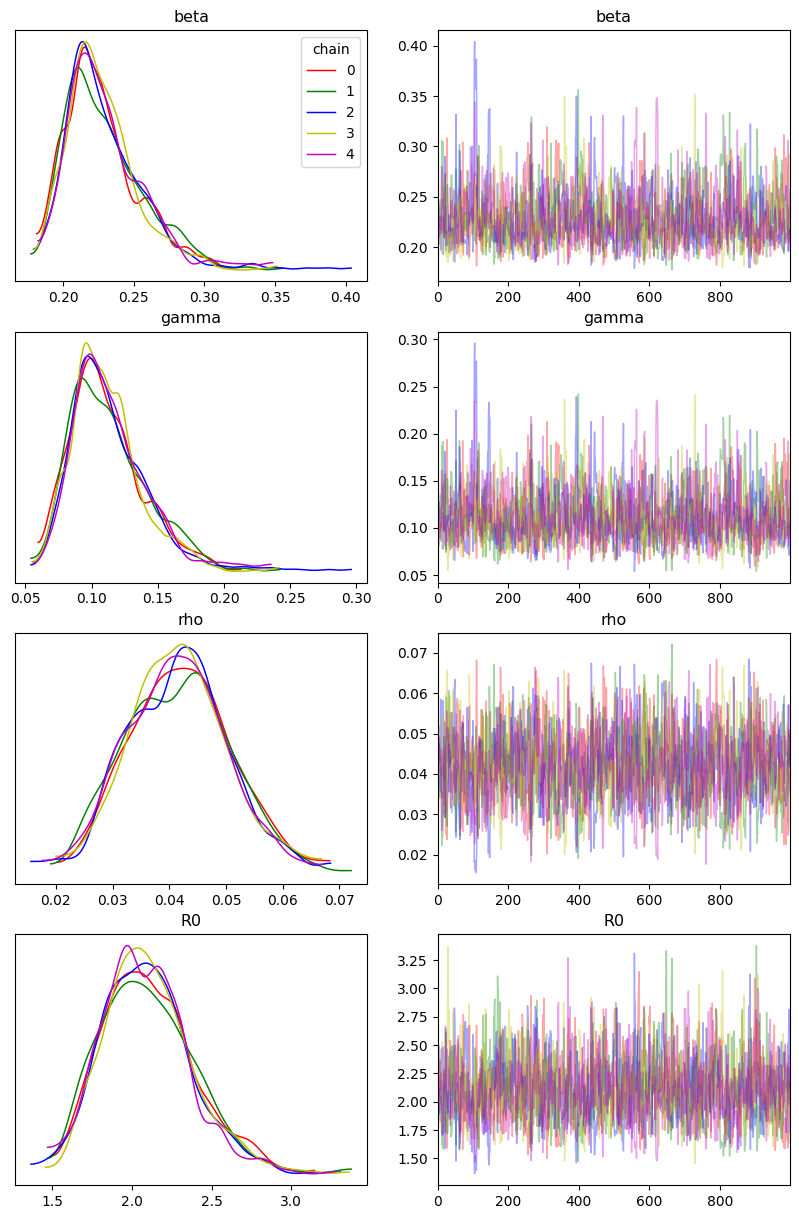

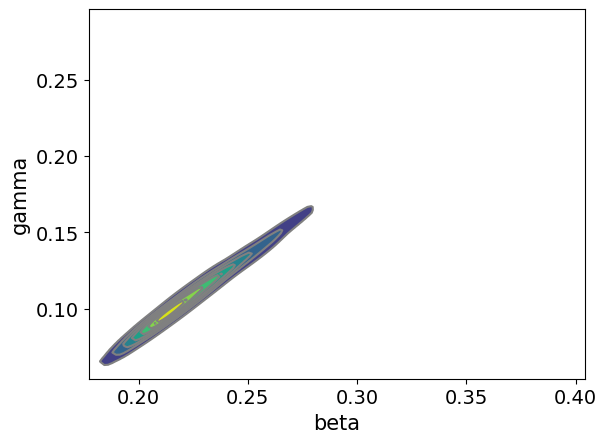

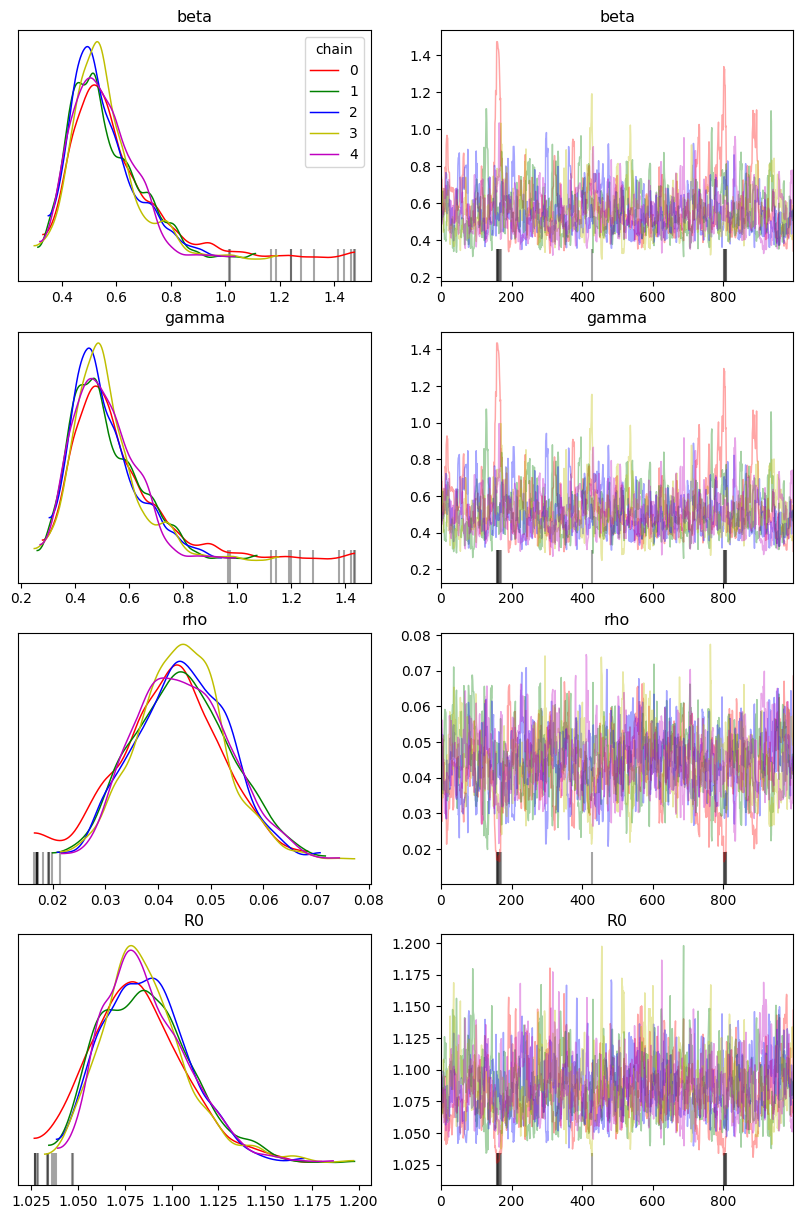

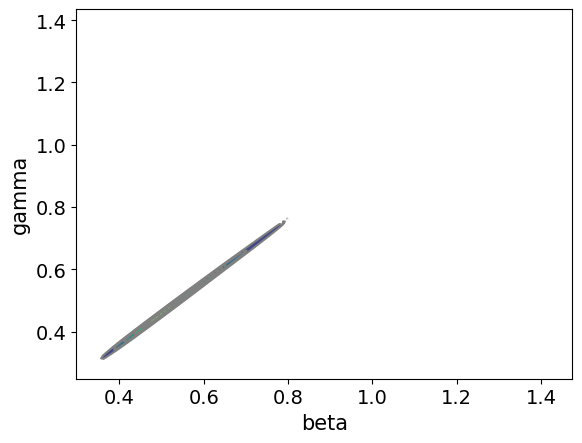

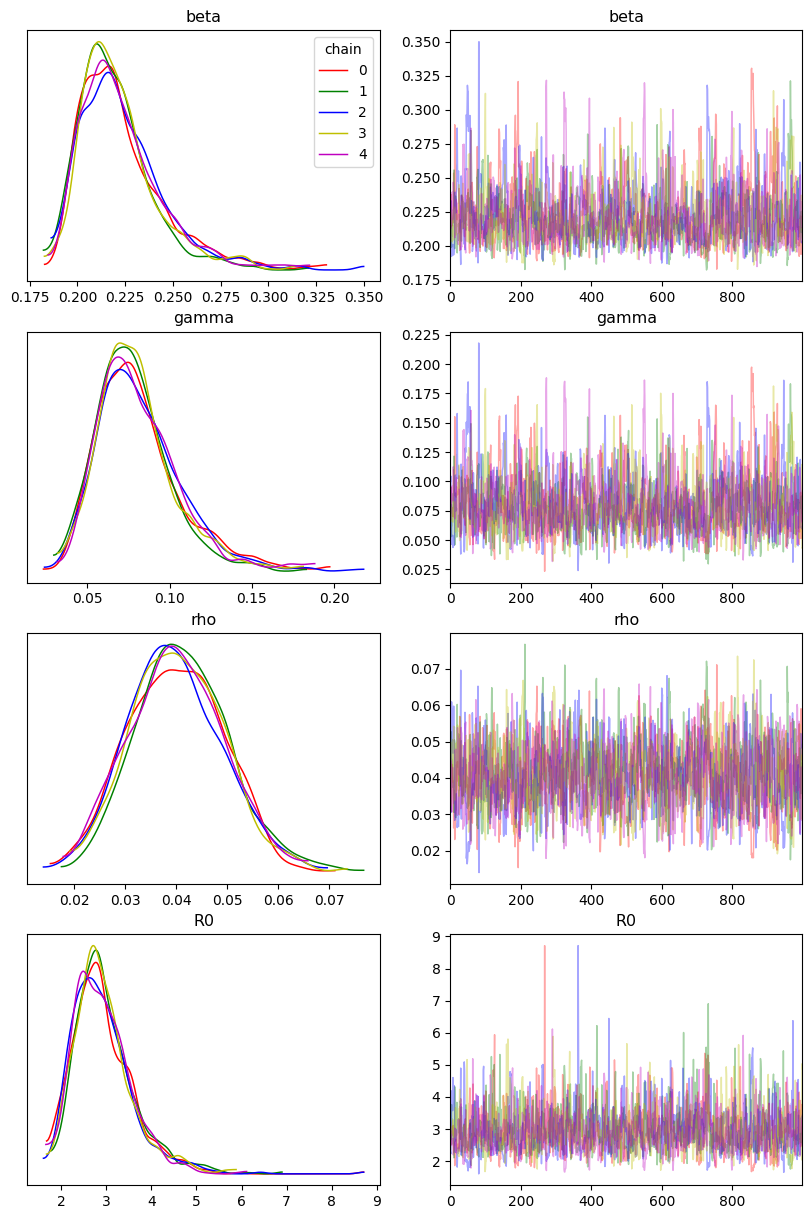

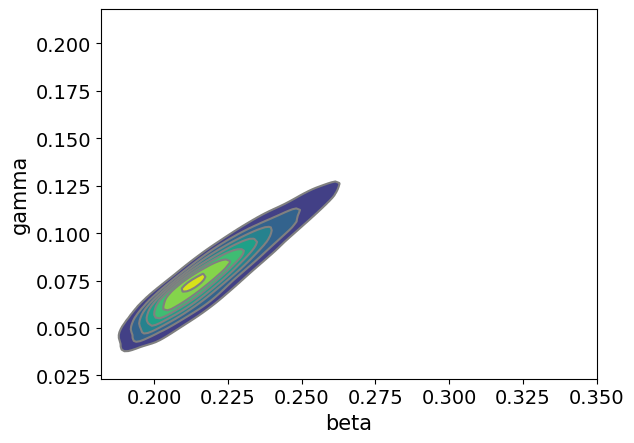

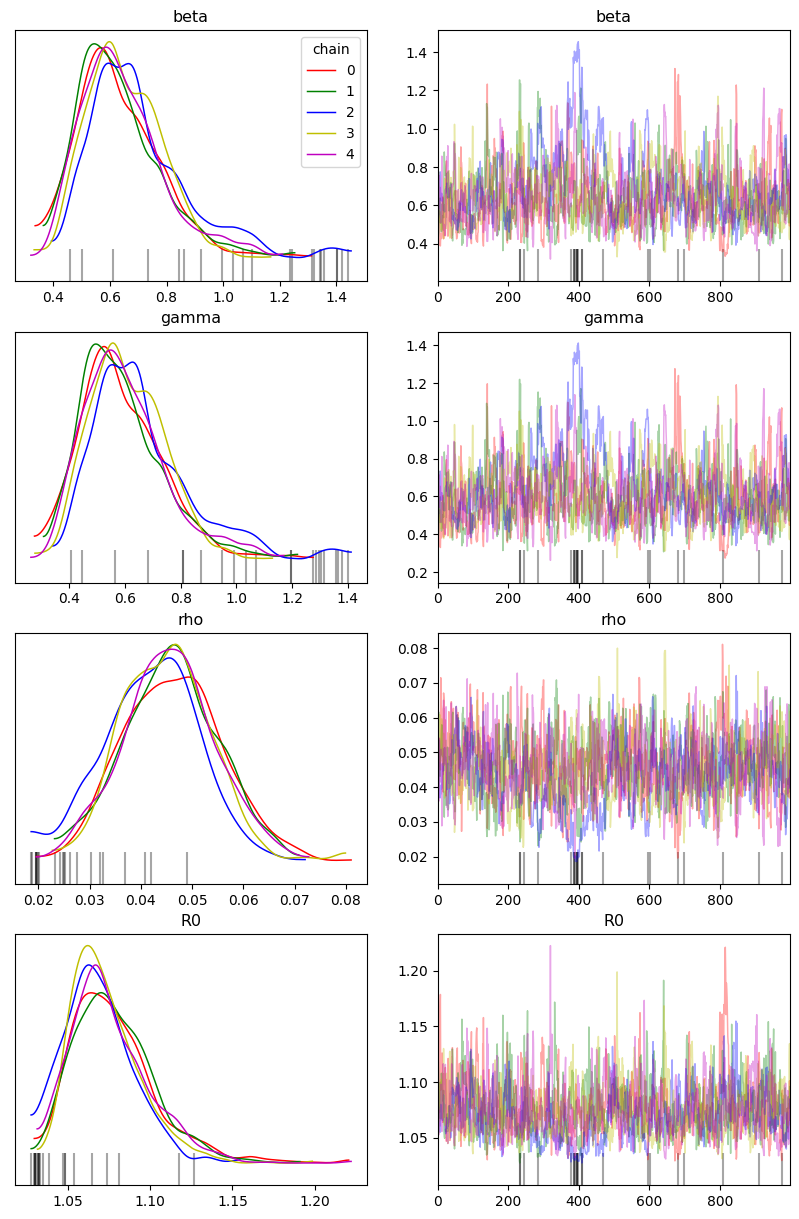

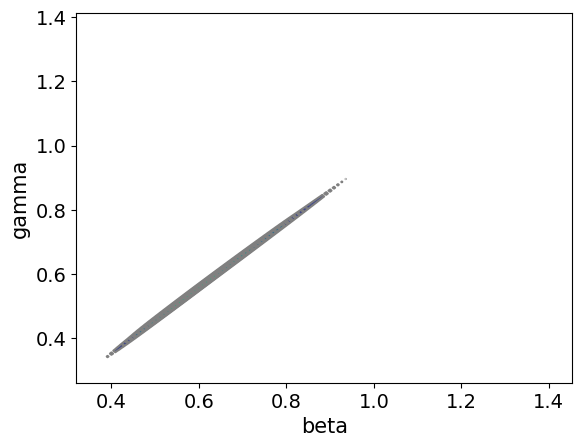

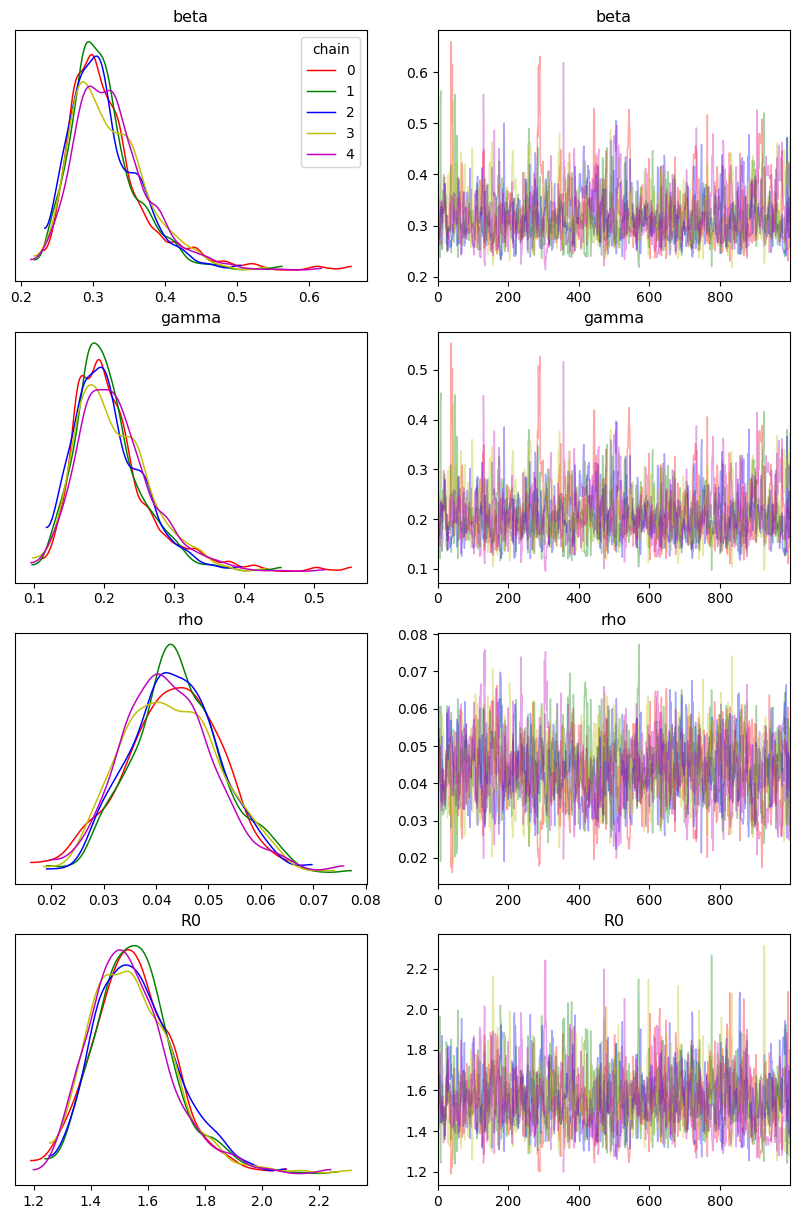

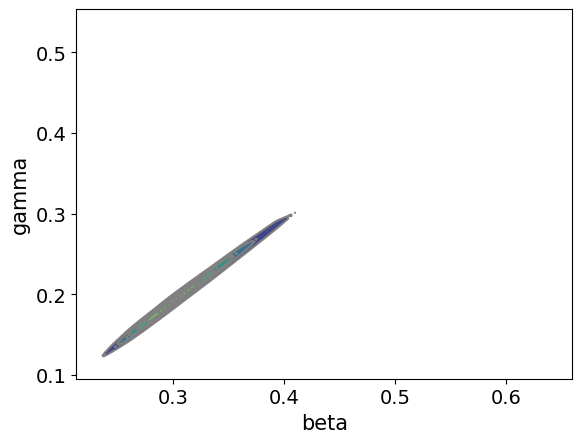

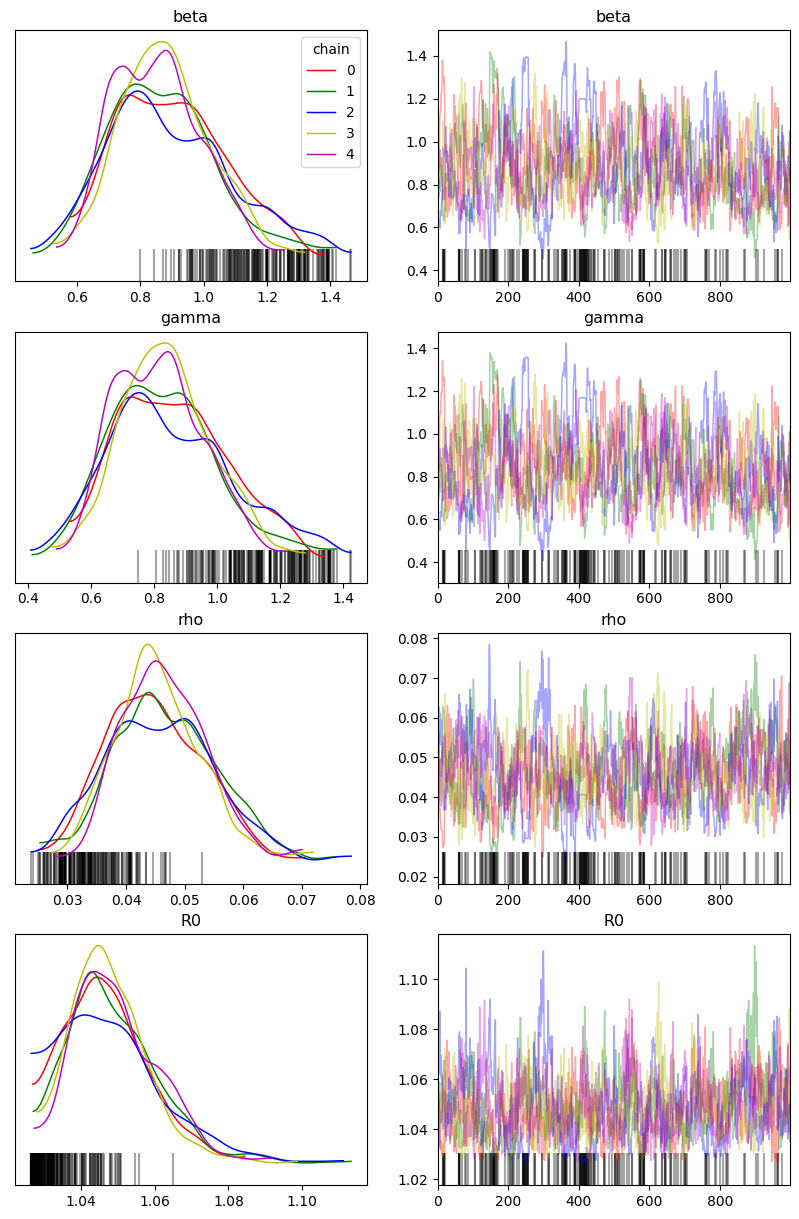

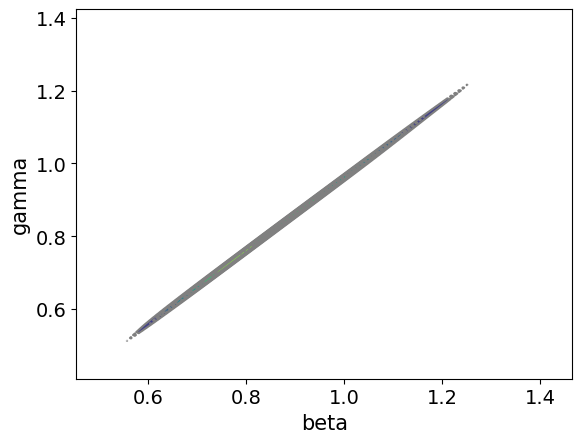

In [15]:
for index, country in enumerate(quarantine_one_results):
    for analysis in country:
        plotMCMC(analysis)